In [ ]:
pip install pyspark

In [ ]:
!python --version

Python 3.11.12


In [ ]:
!pip show pyspark

Name: pyspark
Version: 3.5.5
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: py4j
Required-by: google-spark-connect


In [ ]:
pip install catboost lightgbm scikit-learn matplotlib seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


# Implementation using AER_credit_card_data.csv dataset

[LightGBM] [Info] Number of positive: 206, number of negative: 717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223185 -> initscore=-1.247200
[LightGBM] [Info] Start training from score -1.247200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

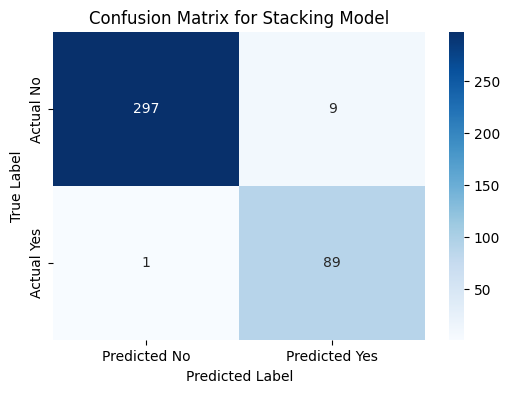

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col, mean
from pyspark.ml import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from prettytable import PrettyTable

# Suppress warnings
warnings.filterwarnings("ignore")

# Initialize Spark session
spark = SparkSession.builder.appName("BigData_Project").getOrCreate()

# Load dataset
data = spark.read.csv("AER_credit_card_data.csv", header=True, inferSchema=True)

# Define columns
categorical_cols = ['owner', 'selfemp']
continuous_cols = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
target_col = "card"

# Impute missing values if any (continuous)
for col_name in continuous_cols:
    mean_val = data.select(mean(col(col_name))).first()[0]
    if mean_val is not None:
        data = data.fillna({col_name: mean_val})

# Impute categorical with mode
for col_name in categorical_cols:
    mode_row = data.groupBy(col_name).count().orderBy("count", ascending=False).first()
    if mode_row:
        data = data.fillna({col_name: mode_row[0]})

# Index categorical columns
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index").fit(data) for col_name in categorical_cols]
data = Pipeline(stages=indexers).fit(data).transform(data)

# Index target column
label_indexer = StringIndexer(inputCol=target_col, outputCol="label").fit(data)
data = label_indexer.transform(data)

# Assemble features
feature_cols = [c + "_index" for c in categorical_cols] + continuous_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Convert to Pandas for sklearn
data_pd = data.select("features", "label").toPandas()
features_np = np.array(data_pd["features"].tolist())
labels_np = data_pd["label"].astype(int).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.3, random_state=42)

# Base models
base_models = [
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('HistGradientBoost', HistGradientBoostingClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=SklearnLogisticRegression())
stacking_model.fit(X_train, y_train)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else np.zeros_like(y_pred)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Log Loss": log_loss(y_test, y_pred_proba) if hasattr(model, 'predict_proba') else "N/A",
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R-squared": r2_score(y_test, y_pred),
        "MAPE": np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100
    }

# Evaluate all models
performance_results = {name: evaluate_model(model.fit(X_train, y_train), X_test, y_test) for name, model in base_models}
performance_results["Stacking Model"] = evaluate_model(stacking_model, X_test, y_test)

# Display performance table
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC", "Log Loss", "MSE", "RMSE", "MAE", "R-squared", "MAPE"]
for model_name, metrics in performance_results.items():
    table.add_row([
        model_name,
        round(metrics["Accuracy"], 4),
        round(metrics["Precision"], 4),
        round(metrics["Recall"], 4),
        round(metrics["F1-Score"], 4),
        round(metrics["AUC"], 4),
        metrics["Log Loss"] if metrics["Log Loss"] == "N/A" else round(metrics["Log Loss"], 4),
        round(metrics["MSE"], 4),
        round(metrics["RMSE"], 4),
        round(metrics["MAE"], 4),
        round(metrics["R-squared"], 4),
        round(metrics["MAPE"], 4)
    ])

print("\nModel Comparison Table:")
print(table)

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, stacking_model.predict(X_test)), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Confusion Matrix for Stacking Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

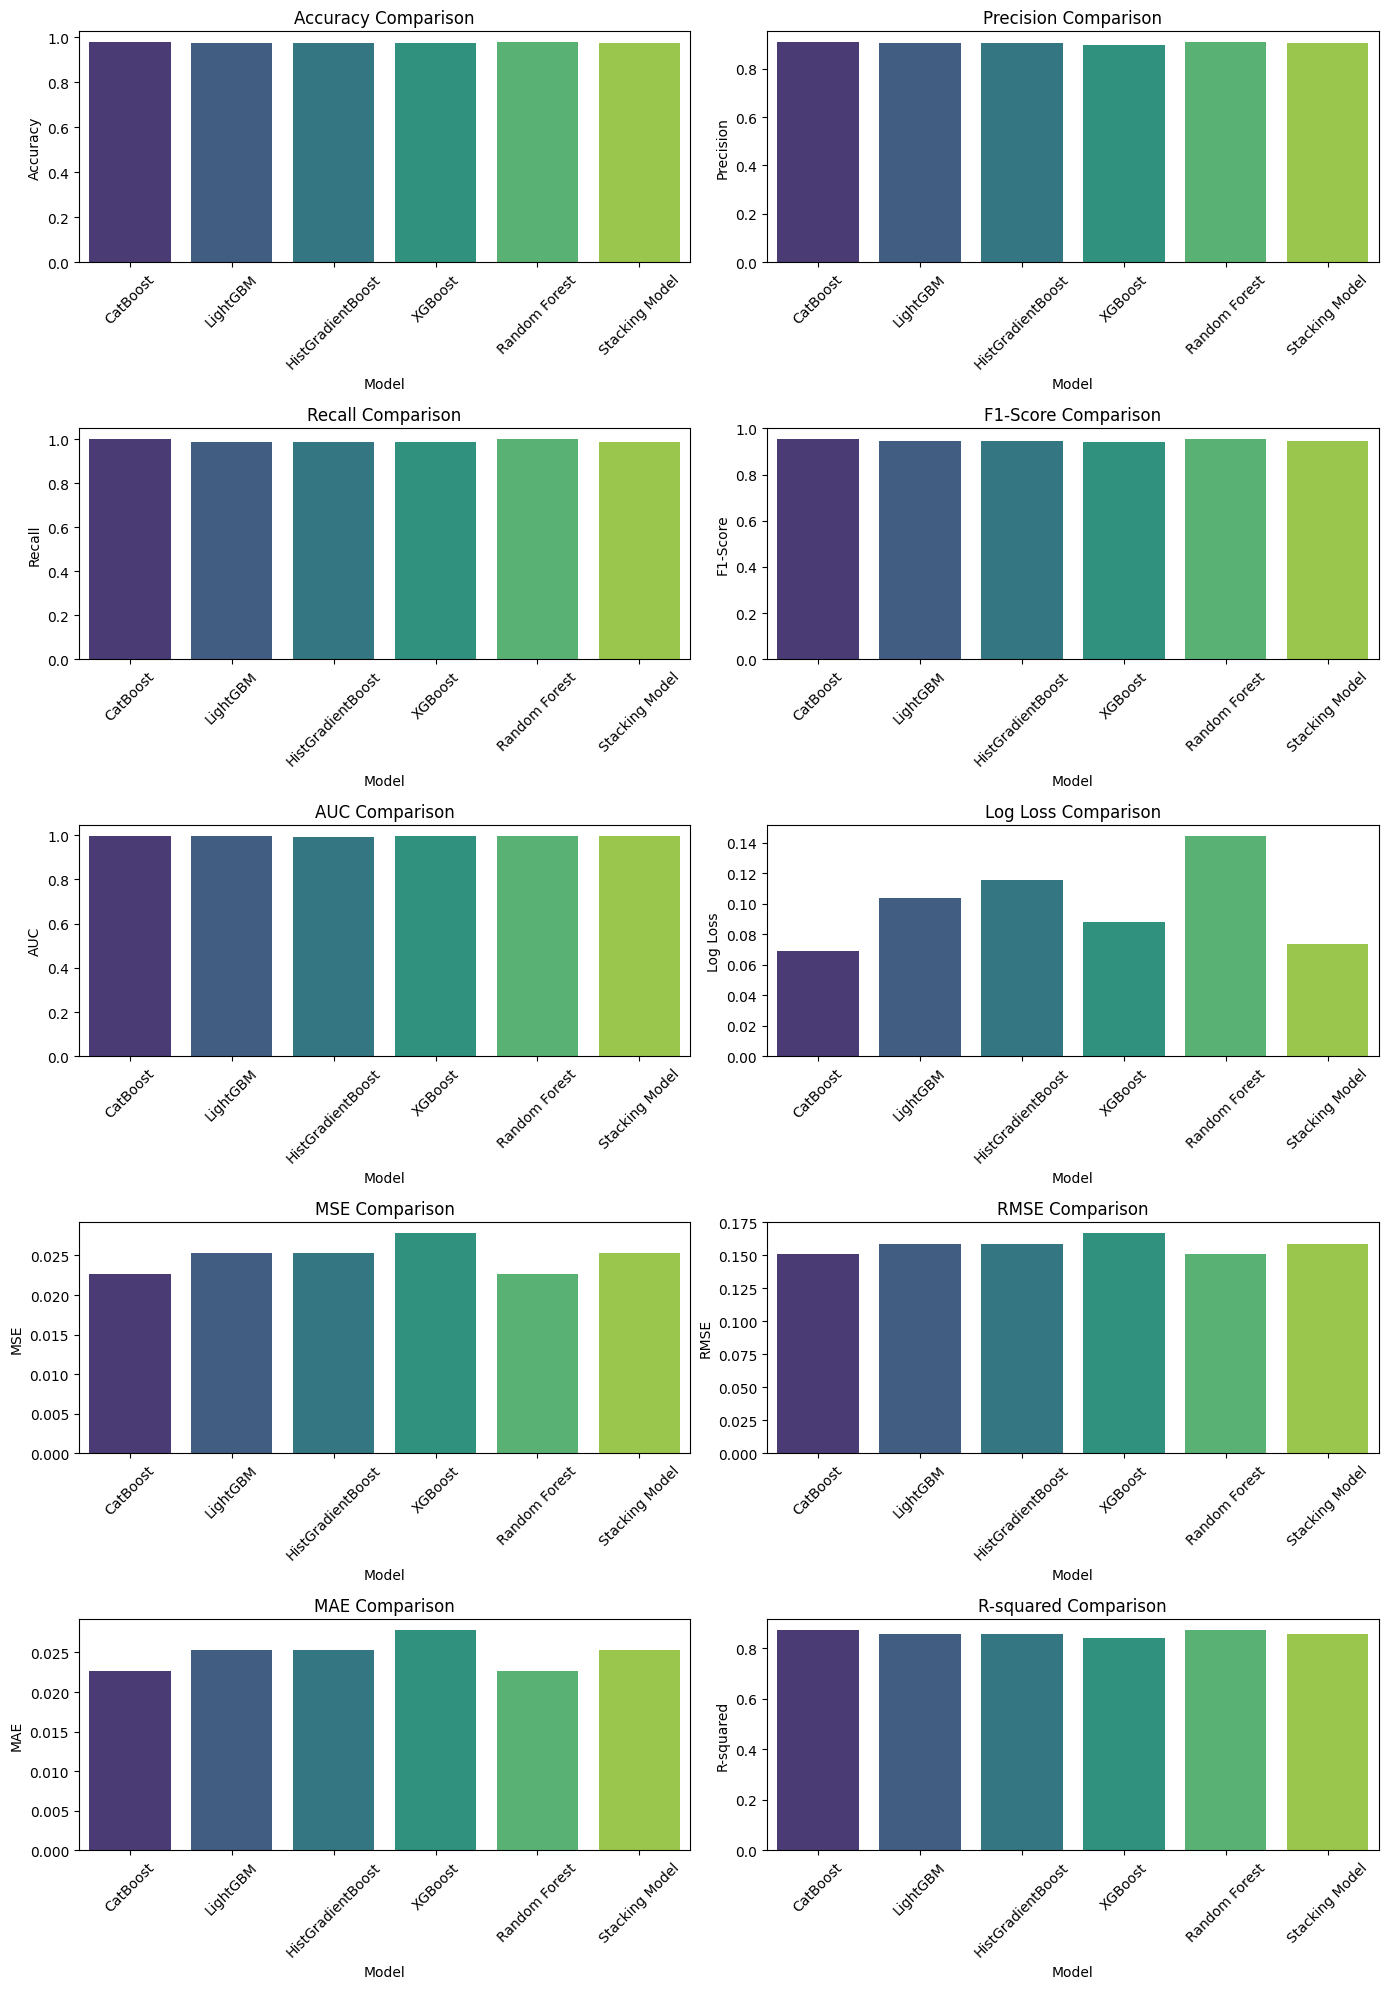

In [ ]:
# Prepare performance data for bar plots
numeric_metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC", "Log Loss", "MSE", "RMSE", "MAE", "R-squared"]
performance_data = {metric: [] for metric in numeric_metrics}
model_names = list(performance_results.keys())

# Filter out non-numeric entries like "N/A"
for metric in numeric_metrics:
    for model in model_names:
        val = performance_results[model][metric]
        performance_data[metric].append(np.nan if val == "N/A" else round(val, 4))

# Create DataFrame
performance_data["Model"] = model_names
df_perf = pd.DataFrame(performance_data)
df_perf.set_index("Model", inplace=True)

# Plotting
valid_metrics = [metric for metric in df_perf.columns if df_perf[metric].dtype != 'O']  # Only numeric columns
n_metrics = len(valid_metrics)
ncols = 2
nrows = (n_metrics + ncols - 1) // ncols  # Ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axs = axs.flatten()

for i, metric in enumerate(valid_metrics):
    sns.barplot(x=df_perf.index, y=metric, data=df_perf.reset_index(), ax=axs[i], palette="viridis")
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel("Model")
    axs[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
!pip install rtdl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

# Implementation of FT-Transformer on AER_credit_card_data.csv dataset

Epoch 1/10, Loss: 0.5527, Val Accuracy: 0.8826
Epoch 2/10, Loss: 0.3861, Val Accuracy: 0.8674
Epoch 3/10, Loss: 0.3424, Val Accuracy: 0.9470
Epoch 4/10, Loss: 0.3185, Val Accuracy: 0.9432
Epoch 5/10, Loss: 0.3096, Val Accuracy: 0.9356
Epoch 6/10, Loss: 0.2902, Val Accuracy: 0.9583
Epoch 7/10, Loss: 0.3017, Val Accuracy: 0.9242
Epoch 8/10, Loss: 0.2786, Val Accuracy: 0.9508
Epoch 9/10, Loss: 0.2614, Val Accuracy: 0.9621
Epoch 10/10, Loss: 0.2529, Val Accuracy: 0.9697
Final Validation Accuracy: 96.97%

Model Evaluation Metrics:
Metric         Value          
------------------------------
Precision      0.9802
Recall         0.9802
F1-score       0.9802
AUC            0.9578
Log Loss       1.0922
RMSE           0.1741
MSE            0.0303
MAE            0.0303
R-squared      0.8314
MAPE           15151515153.0303


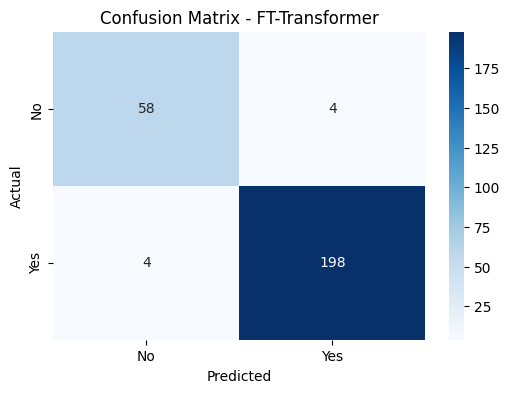

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, r2_score
from rtdl import FTTransformer
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import TensorDataset, DataLoader
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("AER_credit_card_data.csv")

# Define columns
categorical_cols = ['owner', 'selfemp']
continuous_cols = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
target_col = 'card'

# Fill missing values for continuous
for col in continuous_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill missing for categorical
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Encode categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Encode target
df[target_col] = LabelEncoder().fit_transform(df[target_col])

# Prepare features and labels
X = df[categorical_cols + continuous_cols].values.astype(np.float32)
y = df[target_col].values.astype(int)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Add Gaussian Noise (Data Augmentation)
X_train += torch.randn_like(X_train) * 0.01

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define FT-Transformer Model
model = FTTransformer.make_baseline(
    n_num_features=X_train.shape[1],
    cat_cardinalities=None,
    n_blocks=8,
    d_token=128,
    attention_dropout=0.2,
    ffn_d_hidden=256,
    ffn_dropout=0.2,
    residual_dropout=0.2,
    d_out=2  # Binary classification
)

# Move to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=10, steps_per_epoch=len(train_loader))

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch, None)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch, None)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
# Evaluation
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
log_loss_val = log_loss(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100

# Print metrics
print("\nModel Evaluation Metrics:")
print(f"{'Metric':<15}{'Value':<15}")
print("-" * 30)
print(f"{'Precision':<15}{precision:.4f}")
print(f"{'Recall':<15}{recall:.4f}")
print(f"{'F1-score':<15}{f1:.4f}")
print(f"{'AUC':<15}{auc:.4f}")
print(f"{'Log Loss':<15}{log_loss_val:.4f}")
print(f"{'RMSE':<15}{rmse:.4f}")
print(f"{'MSE':<15}{mse:.4f}")
print(f"{'MAE':<15}{mae:.4f}")
print(f"{'R-squared':<15}{r2:.4f}")
print(f"{'MAPE':<15}{mape:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - FT-Transformer")
plt.show()


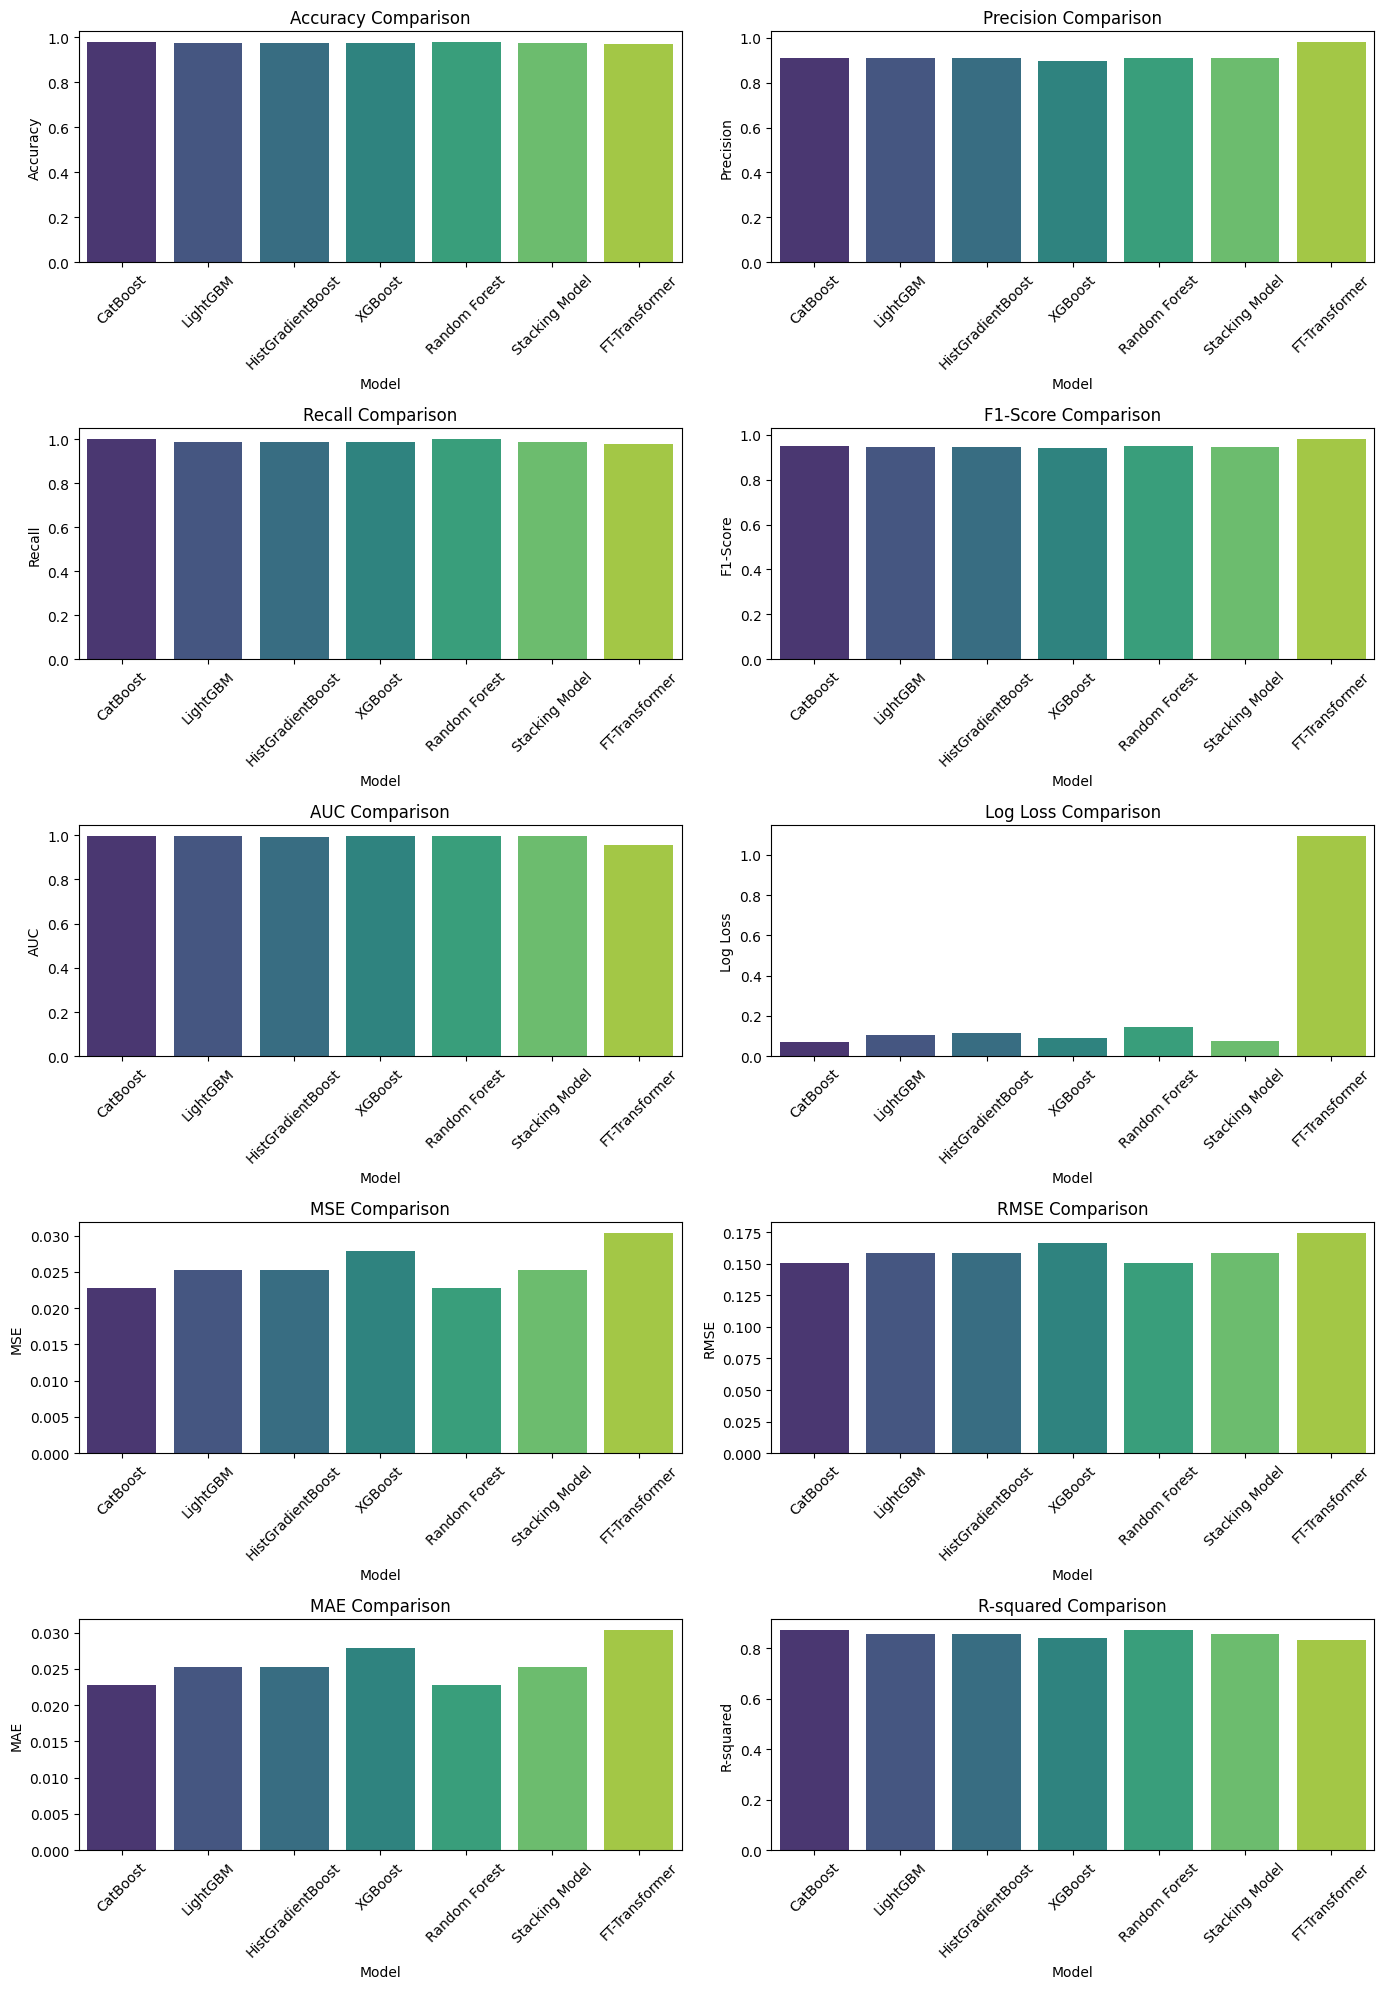

In [ ]:

performance_results["FT-Transformer"] = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "AUC": auc,
    "Log Loss": log_loss_val,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R-squared": r2,
    "MAPE": mape
}

# Prepare performance data for bar plots
numeric_metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC", "Log Loss", "MSE", "RMSE", "MAE", "R-squared"]
performance_data = {metric: [] for metric in numeric_metrics}
model_names = list(performance_results.keys())

# Filter out non-numeric entries like "N/A"
for metric in numeric_metrics:
    for model in model_names:
        val = performance_results[model][metric]
        performance_data[metric].append(np.nan if val == "N/A" else round(val, 4))

# Create DataFrame
performance_data["Model"] = model_names
df_perf = pd.DataFrame(performance_data)
df_perf.set_index("Model", inplace=True)

# Plotting
valid_metrics = [metric for metric in df_perf.columns if df_perf[metric].dtype != 'O']  # Only numeric columns
n_metrics = len(valid_metrics)
ncols = 2
nrows = (n_metrics + ncols - 1) // ncols  # Ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axs = axs.flatten()

for i, metric in enumerate(valid_metrics):
    sns.barplot(x=df_perf.index, y=metric, data=df_perf.reset_index(), ax=axs[i], palette="viridis")
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel("Model")
    axs[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
